In [17]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

### We are starting with members; will need to do customers seperately

In [244]:
master_df1=pd.DataFrame()
master_df2=pd.DataFrame()

dates=['2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05',
      '2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04',
      '2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12','2016-01','2016-02','2016-03',
      '2016-04','2016-05','2016-06','2016-07','2016-08','2016-09']
trial_name='2013-08'
url1='Data/citi_bike_csvs/'
url2=' - Citi Bike trip data.csv'
for date in dates:
    print date,
    print time.ctime()

    url=url1+date+url2
    df=pd.read_csv(url)
    df=df[df['usertype']=='Subscriber']
    if date in dates[14:]:
        df['starttime']=df['starttime'].apply(lambda x: datetime.datetime.strptime(x.split()[0],'%m/%d/%Y'))
    else:
        df['starttime']=df['starttime'].apply(lambda x: datetime.datetime.strptime(x.split()[0],'%Y-%m-%d'))
#     # df['day_of_week']=df['starttime'].apply(lambda x: x.dayofweek)
    df['date']=df['starttime'].apply(lambda x: datetime.datetime.date(x))
    temp1=df.groupby(['date','start station id'])['usertype'].count().to_frame()
    temp2=df.groupby(['start station id'])['birth year','gender'].mean()
    master_df1=pd.concat([master_df1,temp1])
    master_df2=pd.concat([master_df2,temp2])

2013-07 Wed Jan 18 15:34:10 2017
2013-08 Wed Jan 18 15:34:26 2017
2013-09 Wed Jan 18 15:34:45 2017
2013-10 Wed Jan 18 15:35:06 2017
2013-11 Wed Jan 18 15:35:28 2017
2013-12 Wed Jan 18 15:35:43 2017
2014-01 Wed Jan 18 15:35:53 2017
2014-02 Wed Jan 18 15:36:00 2017
2014-03 Wed Jan 18 15:36:05 2017
2014-04 Wed Jan 18 15:36:14 2017
2014-05 Wed Jan 18 15:36:29 2017
2014-06 Wed Jan 18 15:36:47 2017
2014-07 Wed Jan 18 15:37:06 2017
2014-08 Wed Jan 18 15:37:26 2017
2014-09 Wed Jan 18 15:37:45 2017
2014-10 Wed Jan 18 15:38:05 2017
2014-11 Wed Jan 18 15:38:22 2017
2014-12 Wed Jan 18 15:38:34 2017
2015-01 Wed Jan 18 15:38:43 2017
2015-02 Wed Jan 18 15:38:49 2017
2015-03 Wed Jan 18 15:38:54 2017
2015-04 Wed Jan 18 15:39:01 2017
2015-05 Wed Jan 18 15:39:15 2017
2015-06 Wed Jan 18 15:39:33 2017
2015-07 Wed Jan 18 15:39:52 2017
2015-08 Wed Jan 18 15:40:13 2017
2015-09 Wed Jan 18 15:40:35 2017
2015-10 Wed Jan 18 15:41:00 2017
2015-11 Wed Jan 18 15:41:24 2017
2015-12 Wed Jan 18 15:41:45 2017
2016-01 We

In [245]:
df=pd.DataFrame()
temp1=pd.DataFrame()
temp2=pd.DataFrame()

In [373]:
temp=master_df1.reset_index(level=1).copy()
temp=temp.groupby(temp.index)['usertype'].sum().to_frame()
temp=temp.reset_index()
temp['date']=pd.to_datetime(temp['date'])
temp=temp.reset_index()

### Here, we are creating the minimum and maximum populations of bike-riders

In [1003]:
# We are using [:-105] because we want full cycles of data. Using 105 gives us three full cycles
# For an absolute maximum, a first degree polynomial with an increase in the y-intercept seems 
# most appropriate for modeling the maximum bike-riding population
fit=np.polyfit(temp['index'][400:765],temp['usertype'][400:765],2)
fit_fn=np.poly1d(fit)
print [x for x in fit_fn.coeffs]

fit2=np.polyfit(temp['index'][400:765],temp['usertype'][400:765],1)
fit_fn2=np.poly1d(fit2)
print [x for x in fit_fn2.coeffs]

def max_population(day):
    return np.mean([fit_fn2(day),fit_fn2(day)])+15000

# Here, we are checking what the minimum percentage is that will use a bike in unideal conditions
print min(temp['usertype'][180:220]/population(200))
print min(temp['usertype'][550:610]/population(200))
print min(temp['usertype'][900:1000]/population(200))

# It seems like 0.032 is a winner. Last year's winter was pretty mild, so we drop the .14 from the third year. 
# We will use that as our scaling minimum population

def min_population(day):
    return max_population(day)*0.035

[0.71683193822120805, -828.45021189841123, 251226.78466360713]
[5.9421641910750091, 16376.871399698446]
0.0138834523323
0.0146499474744
0.0551505617581


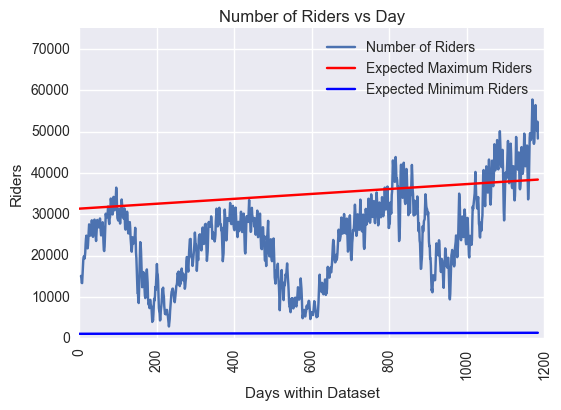

In [1183]:
plt.plot(temp['index'],temp['usertype'].rolling(5).mean(),'-',label='Number of Riders')
plt.plot(temp['index'],[max_population(x) for x in temp['index']],'-',c='red',label='Expected Maximum Riders')
plt.plot(temp['index'],[min_population(x) for x in temp['index']],'-',c='blue',label='Expected Minimum Riders')
plt.xticks(rotation=90)
plt.xlabel('Days within Dataset')
plt.title('Number of Riders vs Day')
plt.ylim(0,75000)
plt.ylabel('Riders')
plt.legend()
plt.show()

### Here, we are finding out the usage percentages on a day of the week basis

In [1005]:
# Here, we adjust for the scaling of the bike-riding population over time by finding the proportion of
# riders compared the expected maximum number of riders at the corresponding date

temp['dayofweek']=temp['date'].apply(lambda x: x.dayofweek)
temp['count/pop']=[y/population(x) for x,y in zip(temp['index'],temp['usertype'])]

usages=[x for x in temp.groupby(['dayofweek'])['count/pop'].mean()]/ \
                max([x for x in temp.groupby(['dayofweek'])['count/pop'].mean()])
usage_dict={
    0:usages[0],
    1:usages[1],
    2:usages[2],
    3:usages[3],
    4:usages[4],
    5:usages[5],
    6:usages[6]
}

### Here, we are prepping our df by importing weather data and slightly modifying columns

In [1039]:
weather=pd.read_csv('/Users/thomas/Data Science Projects/Citi_Bike/Data/weather/NYC_weather_data.csv')

weather=weather[[u'EDT', u'Max TemperatureF', u'Mean TemperatureF', u'Min TemperatureF',\
                u' Mean Humidity',\
                u' Max Wind SpeedMPH', u' Mean Wind SpeedMPH', u' Max Gust SpeedMPH', u'PrecipitationIn', u' Events']]

weather=pd.merge(weather,pd.get_dummies(weather[' Events']),left_index=True,right_index=True)
del weather[' Events']

In [1007]:
weather.head(2)

,EDT,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Humidity,Mean Humidity,Min Humidity,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,Fog,Fog-Rain,Fog-Rain-Snow,Fog-Snow,Rain,Rain-Snow,Snow
0,6/26/13,85,80,74,82,67,51,12.0,4.0,19.0,0.05,0,0,0,0,1,0,0
1,6/27/13,86,80,73,93,75,57,13.0,4.0,24.0,0.24,0,0,0,0,1,0,0


In [1040]:
weather['EDT']=pd.to_datetime(weather['EDT'])

df=pd.merge(temp,weather,left_on='date',right_on='EDT').copy()

df['Expected_Max']=[usage_dict[dayofweek]*max_population(day) for dayofweek,day in zip(df['dayofweek'],df['index'])]
df['Expected_Min']=df['index'].apply(lambda x: min_population(x))
df['PrecipitationIn']=df['PrecipitationIn'].apply(lambda x: x if x!='T' else 0)
df[' Max Wind SpeedMPH']=df[' Max Wind SpeedMPH'].apply(lambda x: x if pd.notnull(x) else 0)
df[' Mean Wind SpeedMPH']=df[' Mean Wind SpeedMPH'].apply(lambda x: x if pd.notnull(x) else 0)


# We will add in public holidays because they will affect whether people are in the city or not
def holiday_finder(date,t_holiday):
    big=[(1,1),(12,25),(12,26),(12,27),(12,28),(12,29),(12,30),(12,31),(7,4)]
    normal=[(1,18),(2,15),(5,30),(9,5),(10,10),(11,11),(11,24)]
    if t_holiday=='big':
        if (date.month,date.day) in big:
            return 1
    elif t_holiday=='normal':
        if (date.month,date.day) in normal:
            return 1
    return 0
df['Big_Holiday']=df['date'].apply(lambda x: holiday_finder(x,'big'))
df['Normal_Holiday']=df['date'].apply(lambda x: holiday_finder(x,'normal'))

for col in ['index','EDT','count/pop',' Max Gust SpeedMPH','Fog']:
    del df[col]

### Now we are ready to try our regressors

In [939]:
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sknn import mlp
import scipy.stats as stats

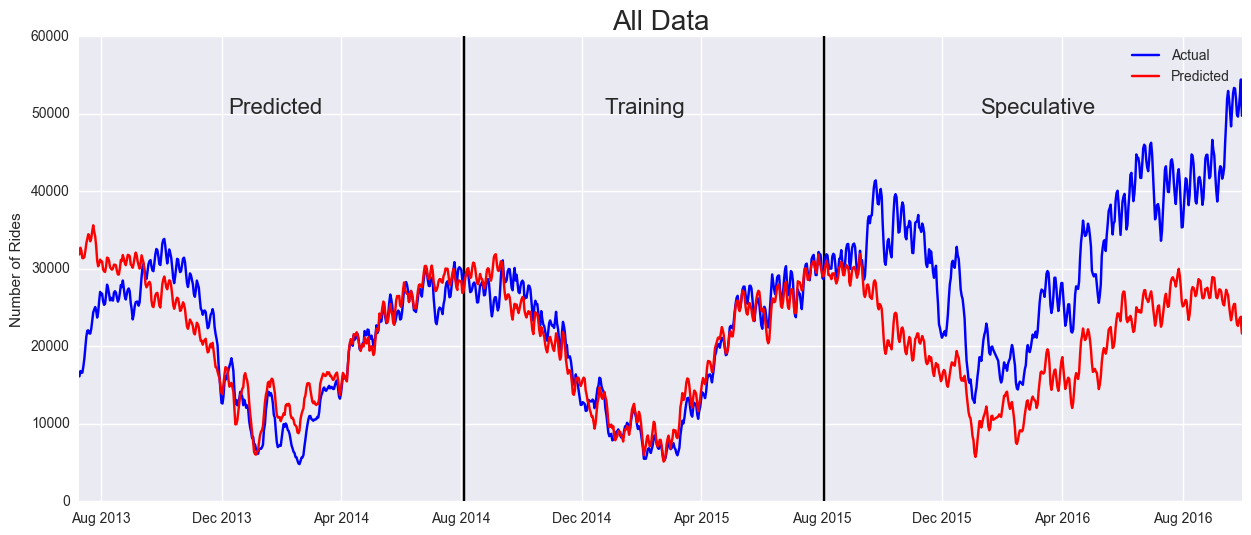

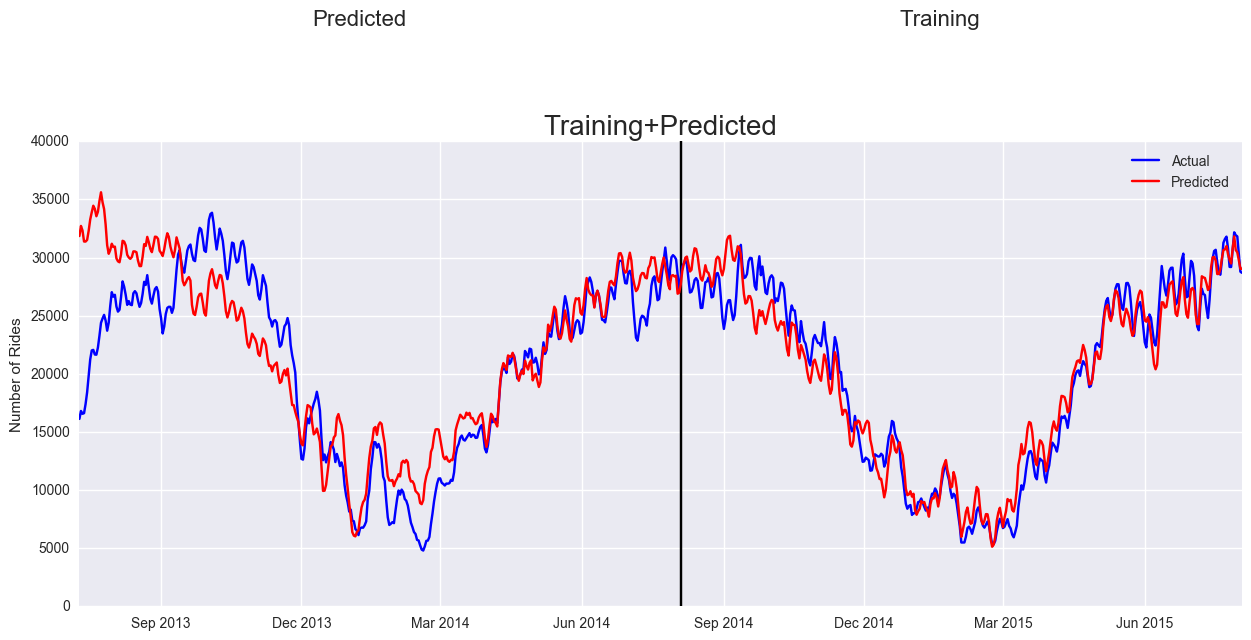

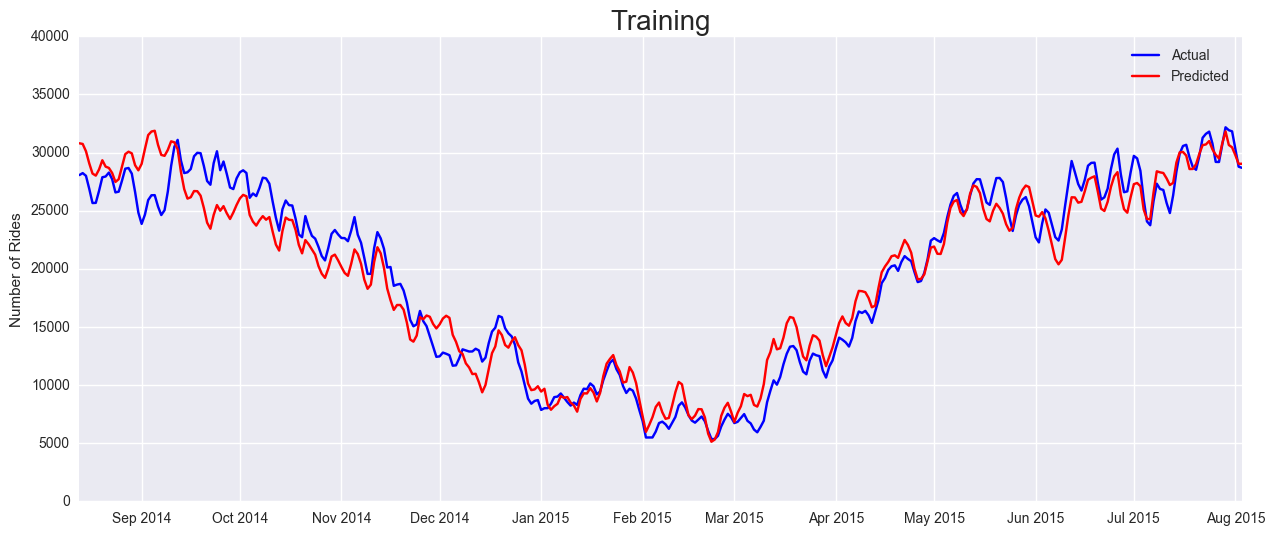

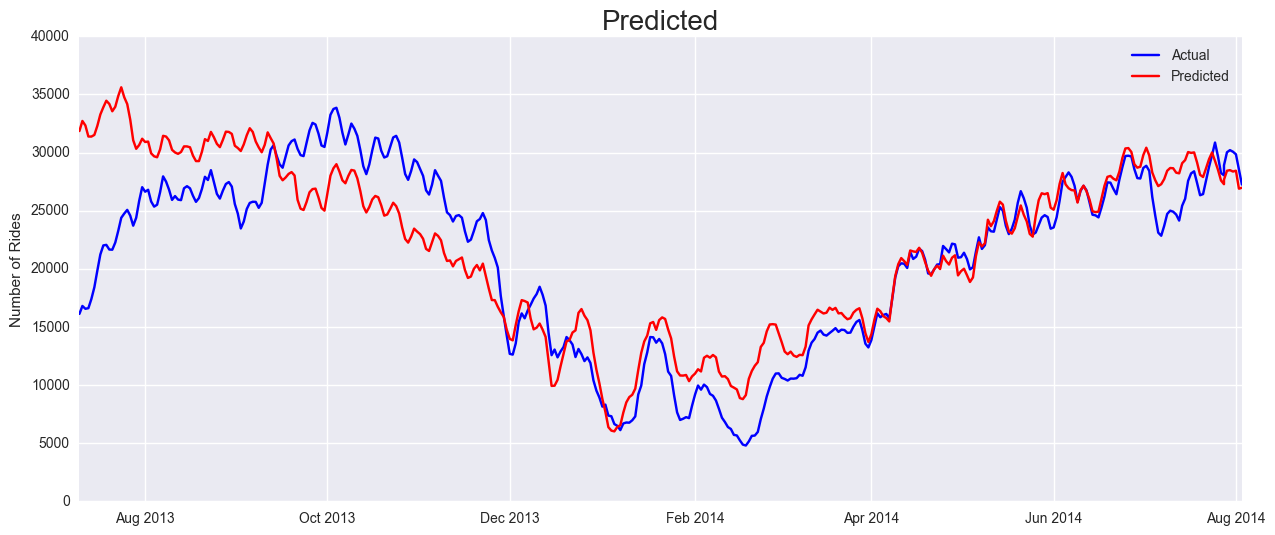

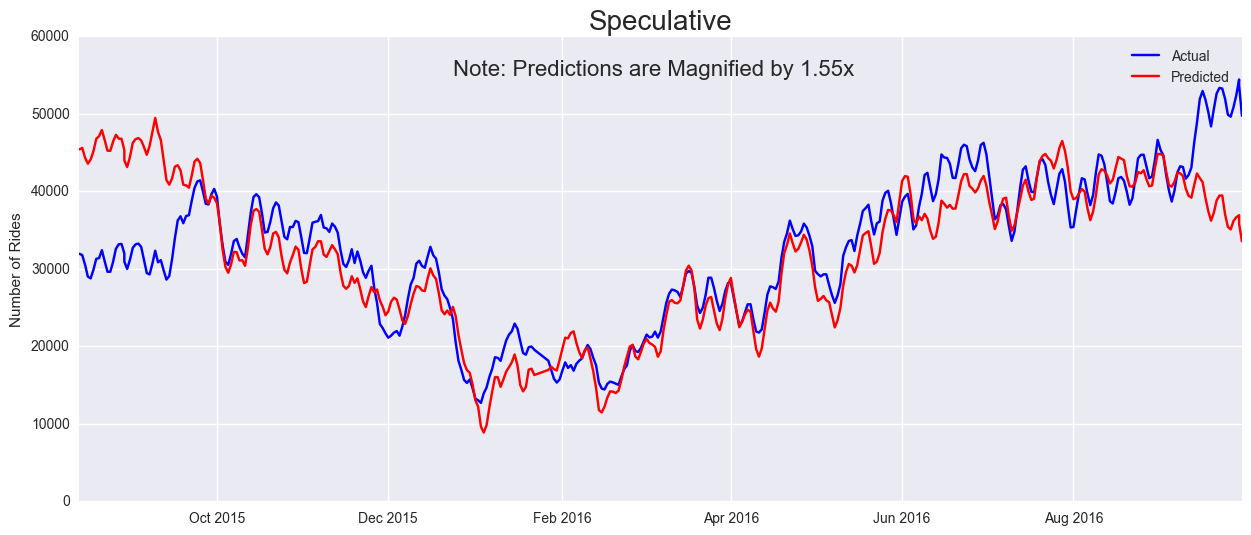

3471.19841362


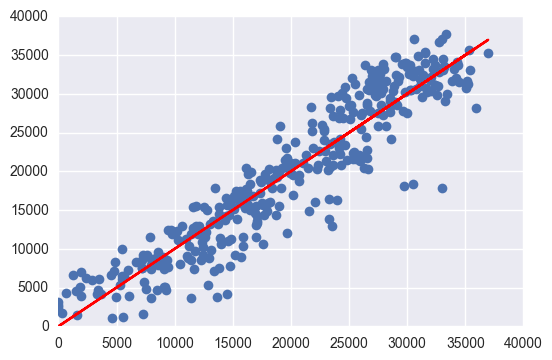

5139.62993712


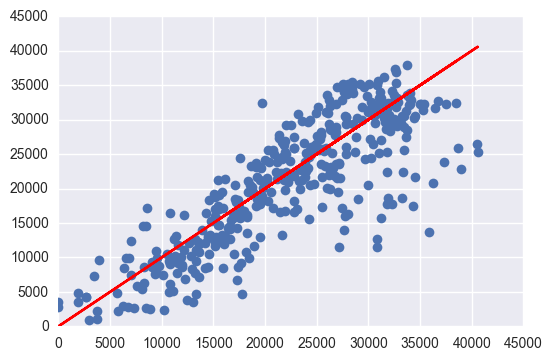

Pre-Residual    : 0.000517103372278
Post-Residual  1: 0.0541381805228


In [1186]:
init=400
threshold=-422
X=df.iloc[init:threshold]
y=df.iloc[:init]
speculative=df.iloc[threshold:]

x_train=X[X.columns[3:]]
y_train=X['usertype']

x_test= y[y.columns[3:]]
y_test= y['usertype']

speculative_x=speculative[speculative.columns[3:]]
speculative_y=speculative['usertype']

full_data_x=df[df.columns[3:]].iloc[:threshold]
full_data_y=df['usertype'].iloc[:threshold]

all_data_x=df[df.columns[3:]]
all_data_y=df['usertype']

model=LinearRegression()
model.fit(x_train,y_train)

def pred_cleanup(thing):
    return [x if x>=0 else 0 for x in thing]

pred=pred_cleanup(model.predict(x_test))
full_pred=pred_cleanup(model.predict(full_data_x))
spec_pred=pred_cleanup(model.predict(speculative_x))
all_pred=pred_cleanup(model.predict(all_data_x))


window=10

plt.subplots(figsize=(15,6))
plt.plot_date(df['date'],all_data_y.rolling(window).mean(),'-',c='blue',label='Actual')
plt.plot_date(df['date'],pd.DataFrame(all_pred).rolling(window).mean(),'-',c='red',label='Predicted')
plt.vlines([df['date'][400],df['date'][765]],0,60000,color='black')
plt.text(df['date'][160],50000,'Predicted',size=16)
plt.text(df['date'][542],50000,'Training',size=16)
plt.text(df['date'][925],50000,'Speculative',size=16)
plt.title('All Data',size=20)
plt.legend()
plt.ylim(0,60000)
plt.ylabel('Number of Rides')
plt.show()

plt.subplots(figsize=(15,6))
plt.plot_date(df.iloc[:threshold]['date'],full_data_y.rolling(window).mean(),'-',c='blue',label='Actual')
plt.plot_date(df.iloc[:threshold]['date'],pd.DataFrame(full_pred).rolling(window).mean(),'-',c='red',\
                      label='Predicted')
plt.vlines(df['date'][400],0,60000,color='black')
plt.text(df['date'][160],50000,'Predicted',size=16)
plt.text(df['date'][542],50000,'Training',size=16)
plt.title('Training+Predicted',size=20)
plt.ylabel('Number of Rides')
plt.ylim(0,40000)
plt.legend()
plt.show()

plt.subplots(figsize=(15,6))
plt.plot_date(df['date'][init:threshold],full_data_y[init:len(df)-threshold].rolling(window).mean(),'-',c='blue',\
             label='Actual')
plt.plot_date(df['date'][init:threshold],pd.DataFrame(full_pred[init:len(df)-threshold]).rolling(window).mean()\
              ,'-',c='red',label='Predicted')
plt.title('Training',size=20)
plt.ylim(0,40000)
plt.ylabel('Number of Rides')
plt.legend()
plt.show()

plt.subplots(figsize=(15,6))
plt.plot_date(df['date'][:init],full_data_y[:init].rolling(window).mean(),'-',c='blue',label='Actual')
plt.plot_date(df['date'][:init],pd.DataFrame(full_pred[:init]).rolling(window).mean(),'-',c='red',\
                      label='Predicted')
plt.title('Predicted',size=20)
plt.ylim(0,40000)
plt.ylabel('Number of Rides')
plt.legend()
plt.show()

plt.subplots(figsize=(15,6))
plt.plot_date(df['date'][threshold:],pd.DataFrame(speculative_y).rolling(window).mean(),'-',c='blue',\
              label='Actual')
plt.plot_date(df['date'][threshold:],pd.DataFrame(spec_pred).rolling(window).mean()*1.55,'-',c='red',\
                      label='Predicted')
plt.title('Speculative',size=20)
plt.ylim(0,60000)
plt.ylabel('Number of Rides')
plt.text(df['date'][908],55000,'Note: Predictions are Magnified by 1.55x',size=16)
plt.legend()
plt.show()


s1=full_pred[init:len(df)-threshold]
s2=full_pred[:init]
a1=full_data_y[init:len(df)-threshold]
a2=full_data_y[:init]

plt.plot(s1,a1,'o')
plt.plot(s1,s1,'-',c='red')
print np.std([x-y for x,y in zip(s1,a1)])
plt.show()
plt.plot(s2,a2,'o')
plt.plot(s2,s2,'-',c='red')
print np.std([x-y for x,y in zip(s2,a2)])
plt.show()


print "Pre-Residual    :",(sum(full_pred[init:len(df)-threshold])-sum(full_data_y[init:len(df)-threshold]))/\
                        sum(full_data_y[init:len(df)-threshold])
print "Post-Residual  1:",(sum(full_pred[:init])-sum(full_data_y[:init]))/sum(full_data_y[:init])

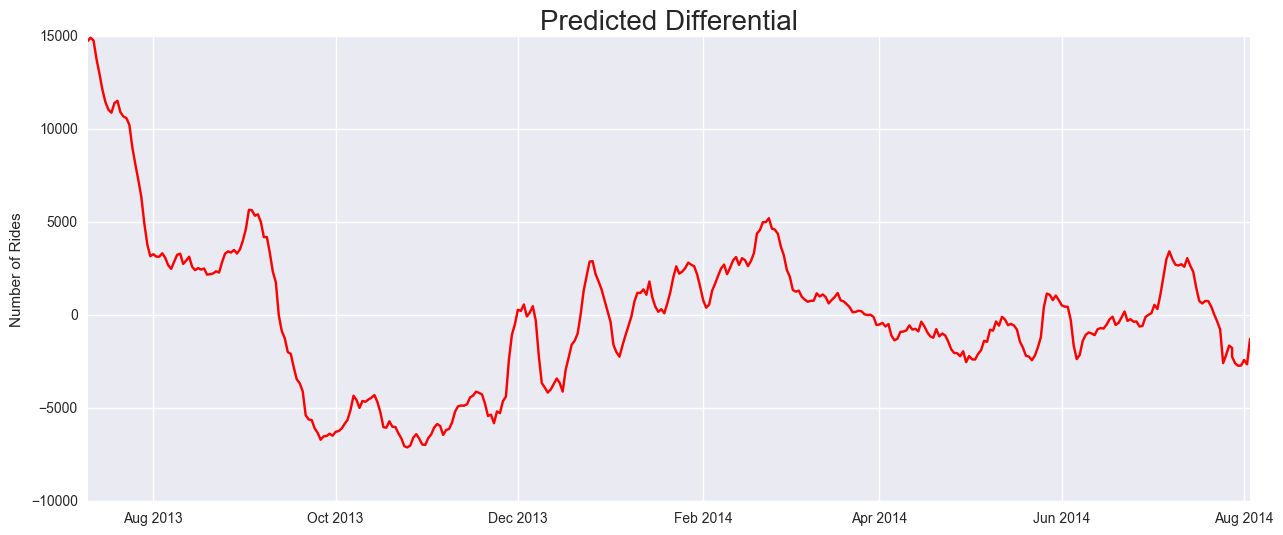

In [1174]:
diff_data=pd.DataFrame(full_pred[:init]-full_data_y[:init]).rolling(window).mean()
plt.subplots(figsize=(15,6))
plt.plot_date(df['date'][:init],diff_data-np.mean(diff_data),'-',c='red')
plt.title('Predicted Differential',size=20)
plt.ylabel('Number of Rides')
plt.show()

0    2404.58784
dtype: float64


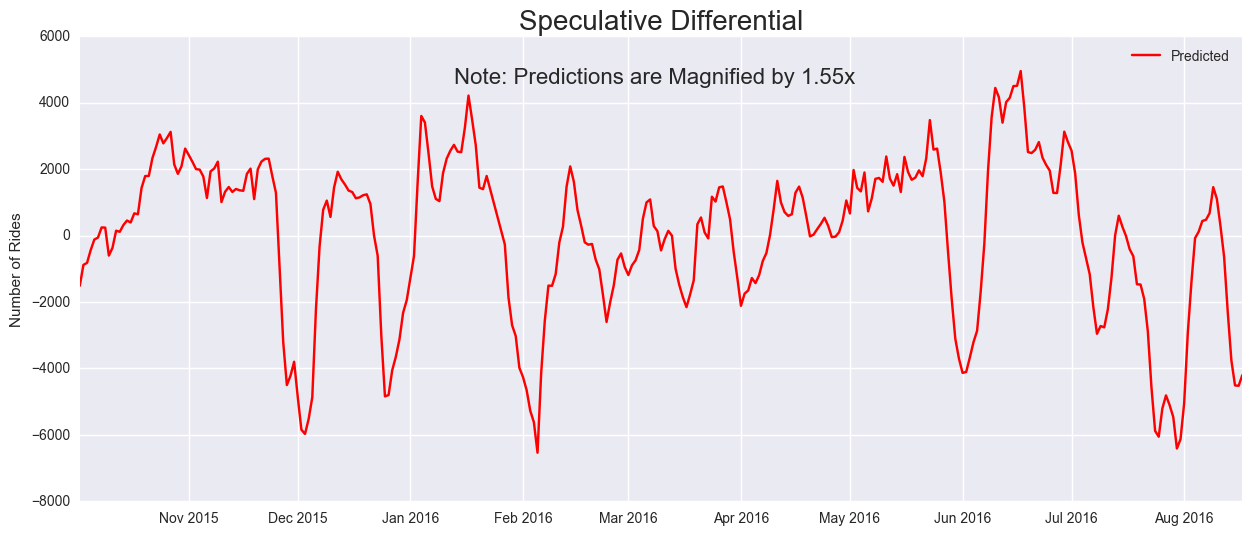

In [1170]:
diff_data=pd.DataFrame([x-y*1.55 for x,y in zip(speculative_y,spec_pred)]).rolling(window).mean()[60:-45]
print np.std(diff_data)
plt.subplots(figsize=(15,6))
plt.plot_date(df['date'][threshold+60:-45],diff_data-np.mean(diff_data),'-',c='red',\
                      label='Predicted')
plt.title('Speculative Differential',size=20)
plt.ylabel('Number of Rides')
plt.text(df['date'][928],4600,'Note: Predictions are Magnified by 1.55x',size=16)
plt.legend()
plt.show()


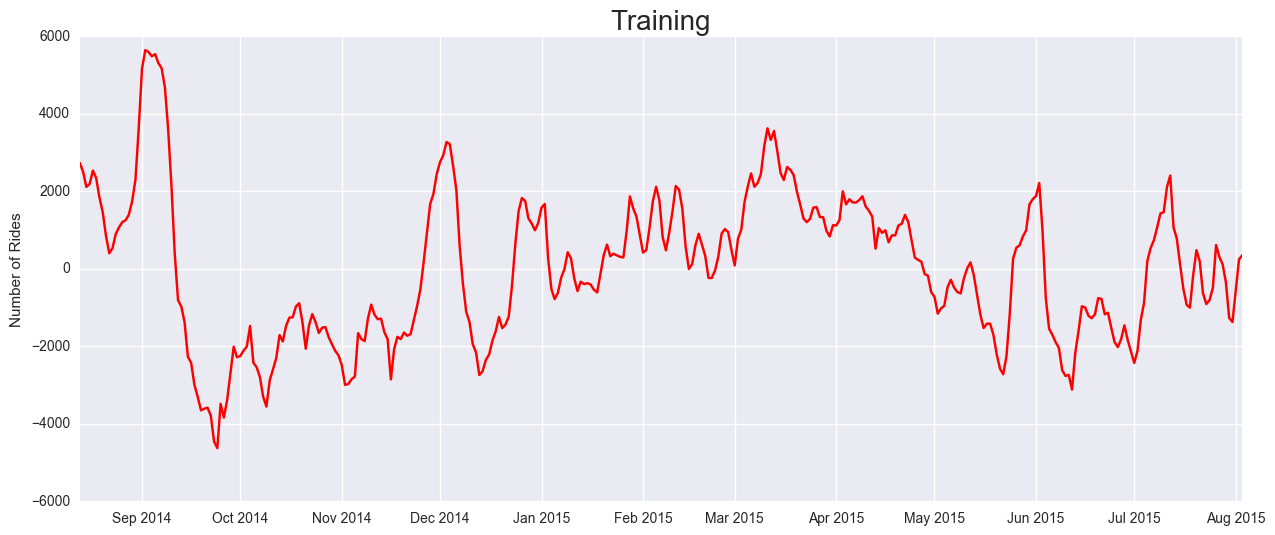

In [1078]:
plt.subplots(figsize=(15,6))
plt.plot_date(df['date'][init:threshold],pd.DataFrame(full_pred[init:len(df)-threshold]-\
                        full_data_y[init:len(df)-threshold]).rolling(window).mean()\
              ,'-',c='red')
plt.title('Training',size=20)
plt.ylabel('Number of Rides')
plt.show()

In [ ]:
plt()